<a href="https://colab.research.google.com/github/alibagheribardi/Regression/blob/main/Graph_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from sklearn.datasets import load_diabetes
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import pandas as pd

def feature_prioritizer(X, target):
    knnreg = KNeighborsRegressor()
    R2 = {}

    # Fit model on all features
    knnreg.fit(X, target)
    y_pred = knnreg.predict(X)
    r2_total = r2_score(target, y_pred)

    # Fit model on each feature individually
    for col in X.columns:
        feature_values = X[[col]]
        knnreg.fit(feature_values, target)
        y_pred = knnreg.predict(feature_values)
        R2[col] = r2_score(target, y_pred)

    # Convert to sorted DataFrame
    r2_df = pd.DataFrame(R2.items(), columns=["Feature", "R2_Score"]).sort_values(by="R2_Score", ascending=False)

    return r2_total, r2_df


In [19]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Load data
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Feature importance using R² score with KNN
def feature_prioritizer(X, target):
    knnreg = KNeighborsRegressor()
    R2 = {}

    knnreg.fit(X, target)
    y_pred = knnreg.predict(X)
    r2_total = r2_score(target, y_pred)

    for col in X.columns:
        feature_values = X[[col]]
        knnreg.fit(feature_values, target)
        y_pred = knnreg.predict(feature_values)
        R2[col] = r2_score(target, y_pred)

    # Convert to DataFrame and sort
    r2_df = pd.DataFrame(R2.items(), columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return r2_total, r2_df

# Run feature prioritizer
total_r2, sorted_features = feature_prioritizer(X, y)
print("Total R2:", total_r2)
print("Feature importance (by R2):")
print(sorted_features)

# Combine features and target into one DataFrame
df = X.copy()
df['target'] = y

# Classification function
def classify_target(val):
    if val < 100:
        return 'Very Low'
    elif 100 <= val <= 150:
        return 'Low'
    elif 151 <= val <= 225:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
df['progression_class'] = df['target'].apply(classify_target)

# Split into classes
very_low_df = df[df['progression_class'] == 'Very Low']
low_df = df[df['progression_class'] == 'Low']
moderate_df = df[df['progression_class'] == 'Moderate']
high_df = df[df['progression_class'] == 'High']

# Show counts
print("\nClass Distribution:")
print(df[['target', 'progression_class']].head(10))

# Show counts
print("\nClass Distribution:")
print(df['progression_class'].value_counts())

Total R2: 0.604957605699507
Feature importance (by R2):
  Feature  R2_Score
2     bmi  0.478340
8      s5  0.443763
3      bp  0.268229
5      s2  0.227701
4      s1  0.200878
9      s6  0.181208
6      s3  0.171093
7      s4  0.128051
0     age  0.017238
1     sex -0.080665

Class Distribution:
   target progression_class
0   151.0          Moderate
1    75.0          Very Low
2   141.0               Low
3   206.0          Moderate
4   135.0               Low
5    97.0          Very Low
6   138.0               Low
7    63.0          Very Low
8   110.0               Low
9   310.0              High

Class Distribution:
progression_class
Very Low    147
Moderate    107
Low          95
High         93
Name: count, dtype: int64


First 20 nearest neighbors of the first test sample:
['High' 'Very Low' 'Very Low' 'Low' 'Low' 'Low' 'Low' 'High' 'Moderate'
 'Low' 'Low' 'Very Low' 'High' 'Very Low' 'Low' 'Moderate' 'High' 'Low'
 'Moderate' 'Low']


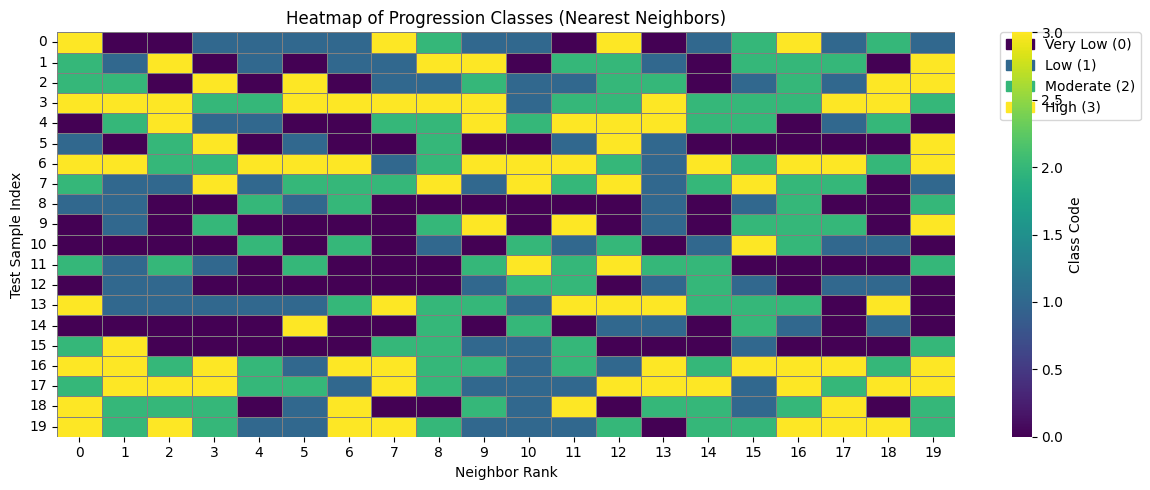

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Load dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Define classification function
def classify_target(val):
    if val < 100:
        return 'Very Low'
    elif 100 <= val <= 150:
        return 'Low'
    elif 151 <= val <= 225:
        return 'Moderate'
    else:
        return 'High'

# Create DataFrame with class labels
df = X.copy()
df['target'] = y
df['progression_class'] = df['target'].apply(classify_target)

# Split into observation and test sets
X_obs, X_test, y_obs, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

# Get class labels for observation set
progression_class_obs = df.loc[X_obs.index, 'progression_class']

# Compute pairwise distances
dist_matrix = pairwise_distances(X_test, X_obs)

# Get indices of nearest observations
nearest_nbhd = np.argsort(dist_matrix, axis=1)

# Create matrix for class labels of nearest neighbors
id_matrix = np.empty_like(dist_matrix, dtype=object)

# Fill id_matrix with class labels
for i, row in enumerate(nearest_nbhd):
    id_matrix[i] = progression_class_obs.iloc[row].values


# Print a sample of neighbor classes
print("First 20 nearest neighbors of the first test sample:")
print(id_matrix[0][:20])

# Map class labels to integers for heatmap
class_map = {'Very Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3}
numeric_id_matrix = np.vectorize(class_map.get)(id_matrix)

# Create color legend for class labels
import matplotlib.patches as mpatches
class_labels = ['Very Low', 'Low', 'Moderate', 'High']
class_colors = [plt.cm.viridis(i/3) for i in range(4)]
patches = [mpatches.Patch(color=class_colors[i], label=f'{label} ({i})') for i, label in enumerate(class_labels)]

# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(numeric_id_matrix[:20, :20], cmap='viridis', annot=False, cbar_kws={'label': 'Class Code'}, linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Progression Classes (Nearest Neighbors)")
plt.xlabel("Neighbor Rank")
plt.ylabel("Test Sample Index")
plt.yticks(rotation=0)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()
